# Comaprison of Soil Moisture Estimates from Satellites in Germany

* Satellite sensors
  * SMAP
    * L-band, 1.41 GHz
    * Ascending at 6PM of local solar time
    * Descending at 6AM of local solar time
    * Ground resolution: 40 km
  * AMSR2
    * C-band 1, 6.9 GHz
    * C-band 2, 7.3 GHz
    * X-band,  10.7 GHz
    * Ascending at 1:30PM of local solar time
    * Descending at 1:30AM of local solar time
    * Ground resolution of C-band 1: 35 x 62 km
    * Ground resolution of C-band 2: 35 x 62 km
    * Ground resolution of X-band:   24 x 42 km
    
* Spatial coverage of interests
  * Germany
* Temporal coverage of interests
  * 2020-08-01 to 2020-08-31
  
Zhan Li, zhanli1986@gmail.com
Created: Sat Sep 26 23:07:26 CEST 2020

__Table of Content__
* Data preparation
  * Download data products from NSIDC DAAC and GES DISC
  * Filter data according to QA flags and valid ranges
  * Reproject filtered data to a common 15-km grid in MODIS sinusoidal projection
* Comparison analysis
  * Spatial comparison of monthly mean per 15km grid cell
  * Temporal comparison of spatial mean per day

In [1]:
# Import necessary libraries
import copy

import numpy as np
import pandas as pd

import rasterio
import rasterio.mask
import fiona
import shapely.geometry
import pyproj

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import plotly
import plotly.express as px
import plotly.graph_objects as go

dpi = 300

## Data preparation
### Download data products from NSIDC DAAC and GES DISC
* SMAP L3 Radiometer Global Daily 36 km EASE-Grid Soil Moisture, Version 6
  * https://nsidc.org/data/SPL3SMP/versions/6
  * Surface soil moisture (cm3/cm3), 36-km gridded daily composite of half-orbit files/swaths, separately from descending passes (6 a.m.) and ascending passes (6 p.m.)
* AMSR2/GCOM-W1 surface soil moisture (LPRM) L3 1 day 10 km x 10 km descending V001
  * https://disc.gsfc.nasa.gov/datasets/LPRM_AMSR2_DS_D_SOILM3_001/summary
  * Surface soil moisture (cm3/cm3), 10-km gridded and downscaled daily composite, from descending passes (1:30 a.m.)
* AMSR2/GCOM-W1 surface soil moisture (LPRM) L3 1 day 10 km x 10 km ascending V001
  * https://disc.gsfc.nasa.gov/datasets/LPRM_AMSR2_DS_A_SOILM3_001/summary
  * Surface soil moisture (cm3/cm3), 10-km gridded and downscaled daily composite, from ascending passes (1:30 p.m.)
  
### Filter data according to QA flags and valid ranges
For simplicity of the current analysis, we only choose pixels of best quality defined by each product.
* SMAP L3 Radiometer Global Daily 36 km EASE-Grid Soil Moisture, Version 6
  * Bit 0 of variable `retrieval_qual_flag` == 0: Soil moisture retrieval has recommended quality. 
  * `soil_moisture` >= `valid_min`: soil moisture estimate above valid minimum, currently 0.02 cm3/cm3
  * `soil_moisture` <= `valid_max`: soil moisture estimate below valid maximum, currently 0.50 cm3/cm3
* AMSR2/GCOM-W1 surface soil moisture (LPRM) L3 1 day 10 km x 10 km V001
  * `mask` == 0: a pixel has (1) no negative optical depth value detected at any band, (2) no high optical depth value detected at any band, (3) valid data, (4) no ice detected. 
  
### Reproject filtered data to a common grid in MODIS sinusoidal projection
All the filtered data (rasters) are reprojected into a common grid in MODIS sinusoidal projection at 15-km resolution using **bilinear** resampling. Notice only pixels in the source products that pass the filtering criteria are used in the reprojection, that is, contributing to each 15-km pixel in the destination projection. 

In [2]:
%%bash
echo "Use the following bash shell scripts that accompany this notebook, "
echo "  To filter and reproject SMAP products: reproj_smap_to_modis_sinu.sh"
echo "  To filter and reproject AMSR2 ascending products: reproj_amsr2_a_to_modis_sinu.sh"
echo "  To filter and reproject AMSR2 descending products: reproj_amsr2_d_to_modis_sinu.sh"

Use the following bash shell scripts that accompany this notebook, 
  To filter and reproject SMAP products: reproj_smap_to_modis_sinu.sh
  To filter and reproject AMSR2 ascending products: reproj_amsr2_a_to_modis_sinu.sh
  To filter and reproject AMSR2 descending products: reproj_amsr2_d_to_modis_sinu.sh


* List of raster files for analysis after filtering and reprojection

In [3]:
raster_list_csv = '../ancdata/raster_list_for_analysis.csv'
raster_list_ss = pd.read_csv(raster_list_csv, 
                             index_col=['sensor','band','asc/dsc','date'], 
                             header=0, 
                             parse_dates=['date'])['csv_path']

* A vector file of Germany (including islands) for subsetting rasters to the region of interests

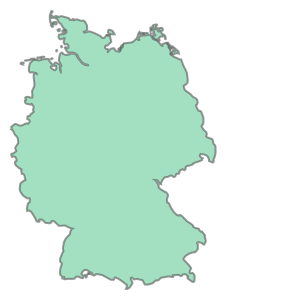

In [4]:
roi_vector = '../ancdata/germany_polygon.gpkg'
with fiona.open(roi_vector, "r") as vector_fobj:
    roi_shapes = [feature["geometry"] for feature in vector_fobj]
    for feature in vector_fobj:
        display(shapely.geometry.shape(feature['geometry']))
    roi_crs = vector_fobj.crs
    roi_features = list(vector_fobj)

## Comparison analysis

### Spatial comparison of monthly mean per 15km grid cell
* Average A.M. and P.M. per day for simplicity at the moment

In [5]:
def files2SummaryImage(cur_ss, scale_factor=1.):
    roi_img_arr = [None]*len(cur_ss)
    for i, raster_fname in enumerate(cur_ss):
        raster_ds = rasterio.open(raster_fname)
        roi_img, roi_transform = rasterio.mask.mask(raster_ds, roi_shapes, 
                                                    all_touched=True, crop=True, indexes=1)
        roi_img = roi_img.astype(np.float)
        roi_img[roi_img==raster_ds.nodatavals[0]] = np.nan
        roi_img = roi_img * scale_factor
        roi_img_arr[i] = roi_img
        raster_ds.close()
    roi_img3d = np.dstack(roi_img_arr)
    roi_img_sum = np.nansum(roi_img3d, axis=2)
    roi_img_sqsum = np.nansum(roi_img3d**2, axis=2)
    roi_img_count = roi_img3d.shape[2] - np.sum(np.isnan(roi_img3d), axis=2)

    return roi_img_count, roi_img_sum, roi_img_sqsum, roi_transform

In [6]:
roi_temporal_mean_dict = dict()
roi_temporal_std_dict = dict()
roi_temporal_count_dict = dict()
roi_sflag_dict = dict()

In [7]:
sensor_name = 'smap'
band_name = 'L'
for sensor_name, band_name, scale_factor in zip(['smap', 'amsr2', 'amsr2', 'amsr2'], 
                                                ['L', 'C1', 'C2', 'X'], 
                                                [1, 1e-2, 1e-2, 1e-2]):
    roi_img_count = 0
    roi_img_sum = 0
    roi_img_sqsum = 0
    my_ss = raster_list_ss.loc[(sensor_name, band_name, slice(None), slice(None))]
    for cur_ss in np.array_split(my_ss, 
                                 range(10, len(my_ss), 10)):
        cur_img_count, cur_img_sum, cur_img_sqsum, roi_transform = files2SummaryImage(cur_ss, scale_factor)
        roi_img_count += cur_img_count
        roi_img_sum += cur_img_sum
        roi_img_sqsum += cur_img_sqsum

    roi_img_mean = np.zeros_like(roi_img_sum)
    roi_img_std = np.zeros_like(roi_img_sum)
    roi_sflag = roi_img_count > 0
    roi_img_mean[roi_sflag] = roi_img_sum[roi_sflag] / roi_img_count[roi_sflag]
    roi_img_std[roi_sflag] = np.sqrt(roi_img_sqsum[roi_sflag]/roi_img_count[roi_sflag]
                                     - roi_img_mean[roi_sflag]**2)

    roi_temporal_mean_dict[(sensor_name, band_name)] = roi_img_mean
    roi_temporal_std_dict[(sensor_name, band_name)] = roi_img_std
    roi_temporal_count_dict[(sensor_name, band_name)] = roi_img_count
    roi_sflag_dict[(sensor_name, band_name)] = roi_sflag

**Spatial Visualization**

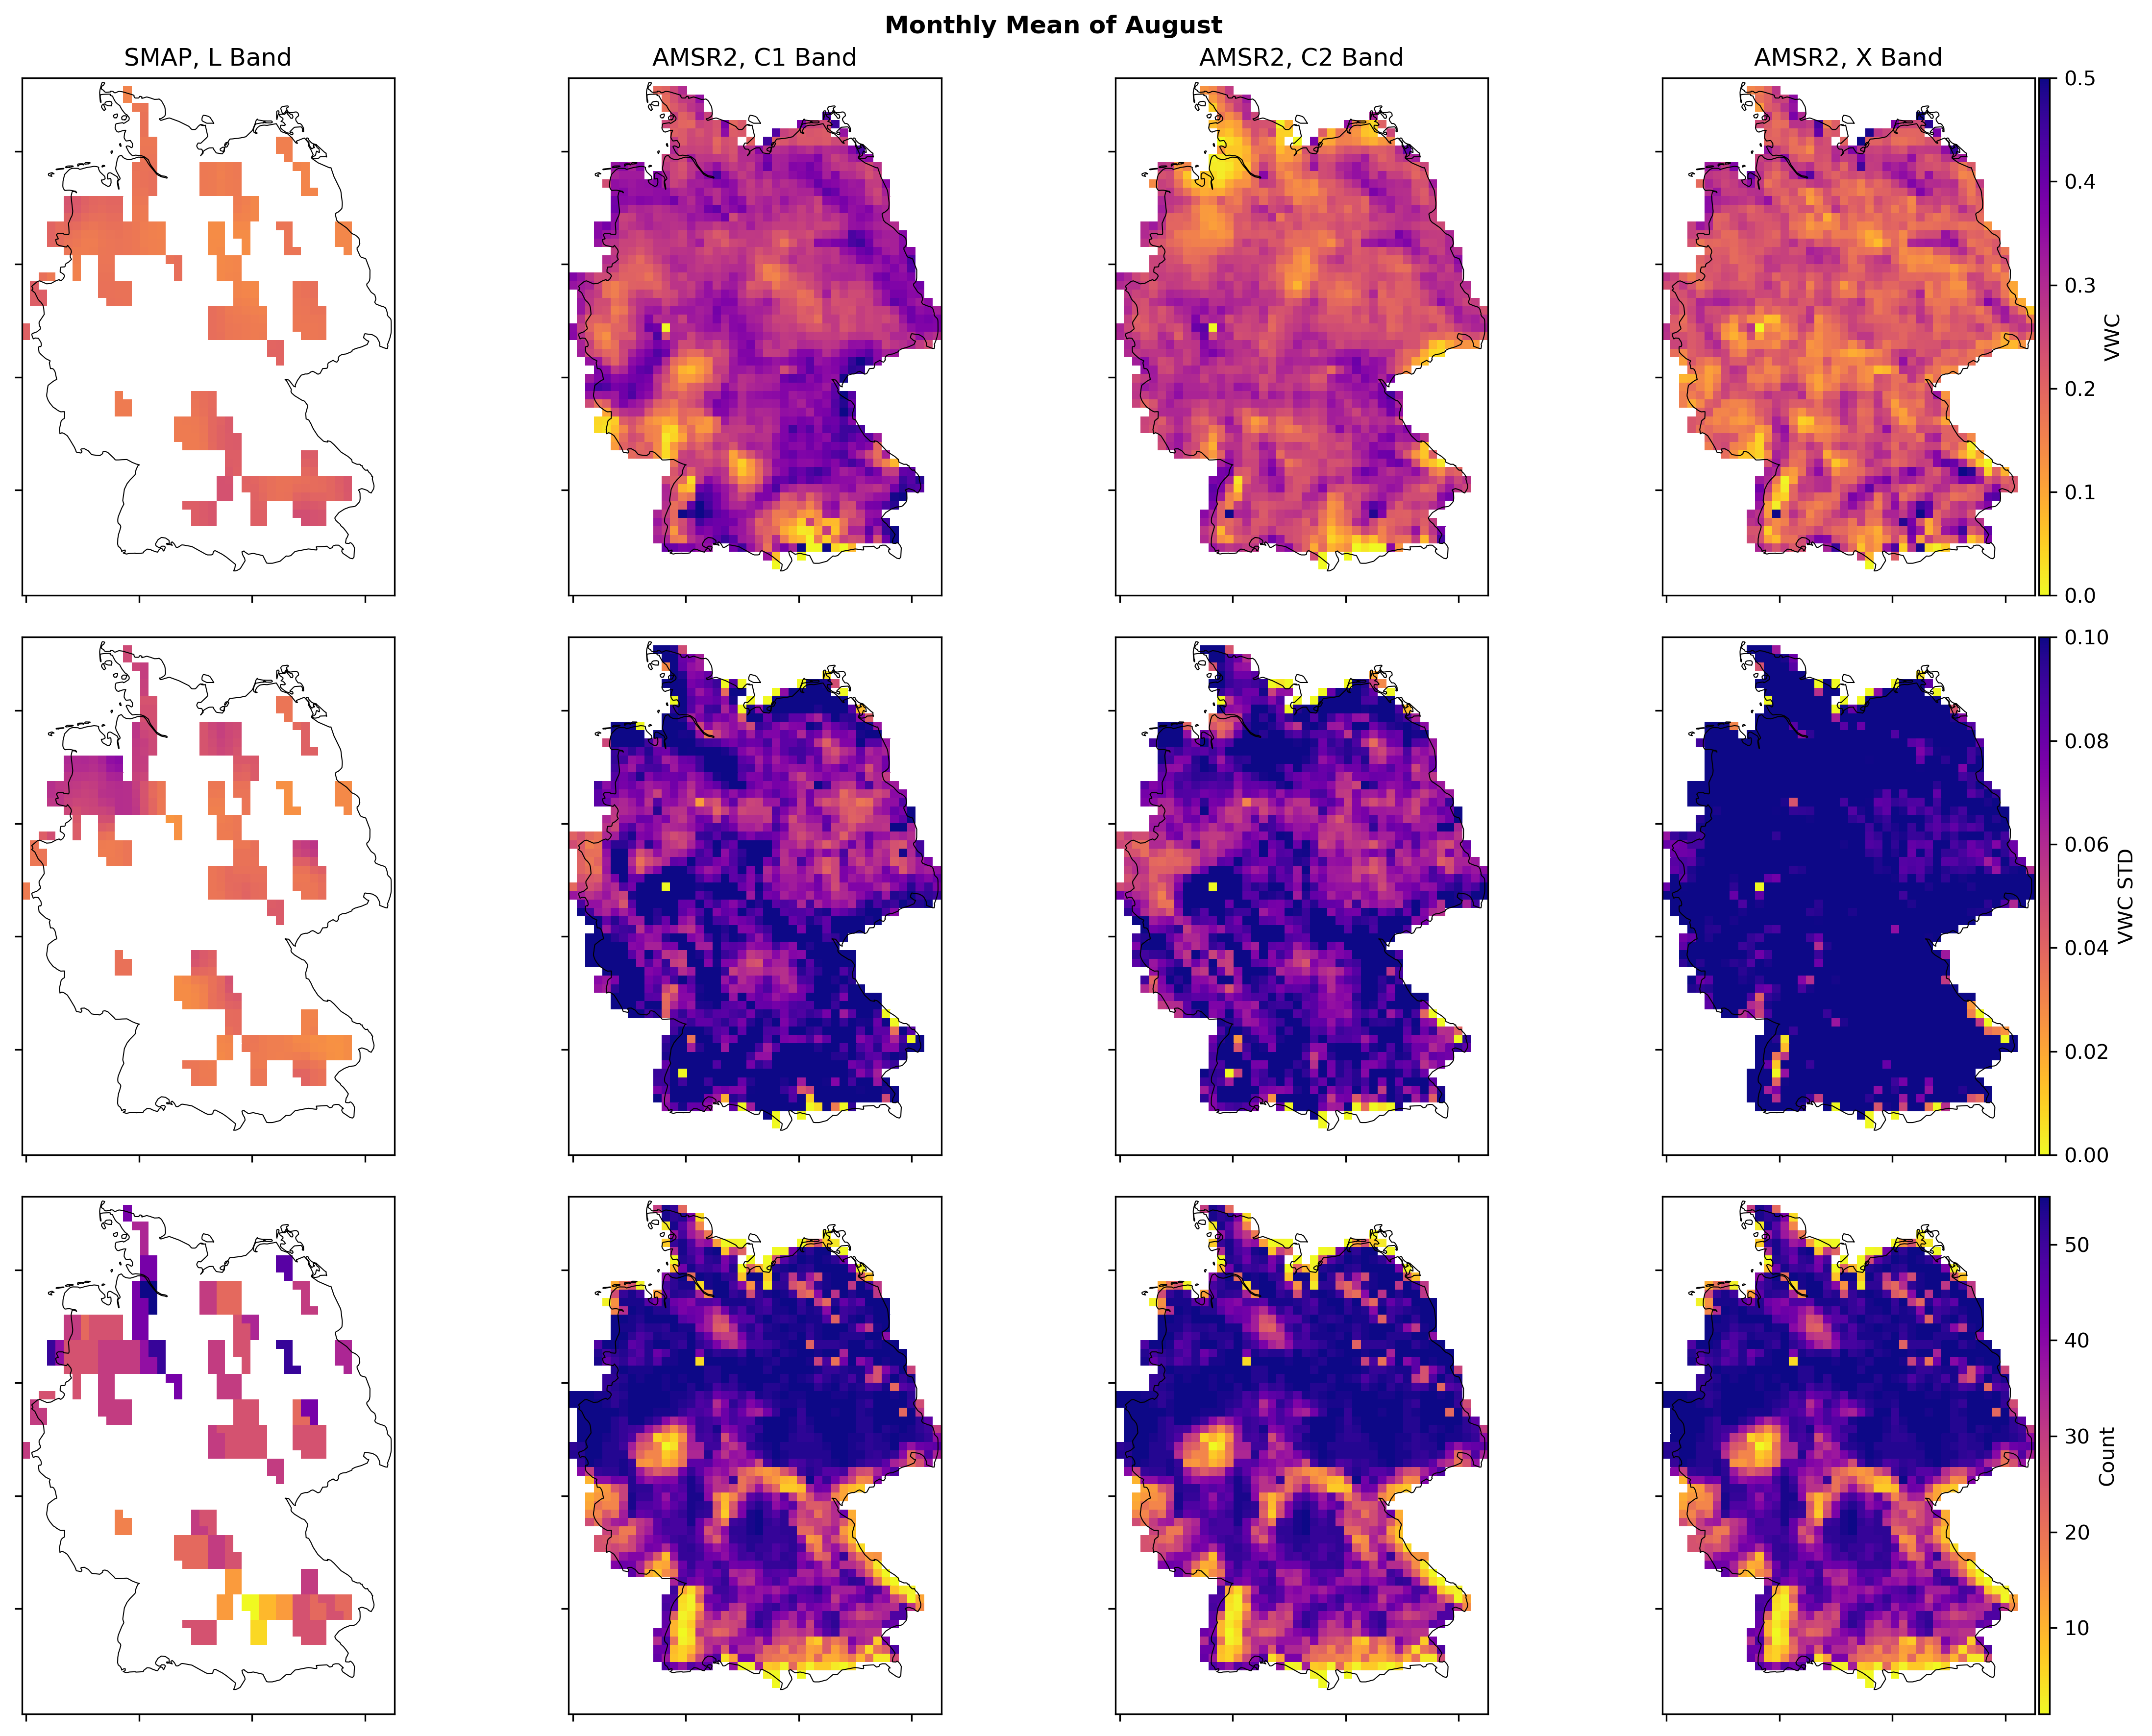

In [8]:
cmap = copy.copy(plt.get_cmap("plasma_r"))
cmap.set_bad("#FFFFFF")
cmap.set_under("#D0D3D4")
mean_norm = mpl.colors.Normalize(0, 0.5)
std_norm = mpl.colors.Normalize(0, 0.1)
count_norm = None #mpl.colors.Normalize(0, 0.02)

def add_geom(geom, ax):
    for gpart in geom['coordinates']:
        x, y = zip(*gpart[0])
        ax.plot(x, y, '-', linewidth=0.5, color='k')

fig = plt.figure(figsize=(16, 12), dpi=dpi)
ax_arr = fig.subplots(3, 4, sharex=True, sharey=True)
for i, (sensor_name, band_name) in enumerate(roi_sflag_dict.keys()):
    roi_sflag = roi_sflag_dict[(sensor_name, band_name)]
    
    ix_img, iy_img = np.meshgrid(np.arange(0, roi_sflag.shape[1]), np.arange(0, roi_sflag.shape[0]))
    x, y = zip(*[roi_transform * (ix, iy) for ix, iy in zip(ix_img.flatten(), iy_img.flatten())])
    x_img, y_img = np.array(x).reshape(ix_img.shape), np.array(y).reshape(iy_img.shape)
    
    roi_img_mean = roi_temporal_mean_dict[(sensor_name, band_name)]
    ax = ax_arr[0, i]
    z_img = roi_img_mean.copy().astype(np.float)
    z_img[np.logical_not(roi_sflag)] = np.nan
    pobj = ax.pcolormesh(x_img, y_img, z_img,
                         cmap=cmap, norm=mean_norm, 
                         shading='nearest')
    add_geom(roi_shapes[0], ax)
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="3%", pad="1%")
    if i==len(roi_sflag_dict)-1:
        plt.colorbar(pobj, cax=cax, orientation='vertical', label='VWC')
    else:
        cax.set_visible(False)
    ax.set_aspect(1)
    ax.yaxis.set_ticklabels([])
    ax.set_title('{0:s}, {1:s} Band'.format(sensor_name.upper(), band_name))

    roi_img_std = roi_temporal_std_dict[(sensor_name, band_name)]
    ax = ax_arr[1, i]
    z_img = roi_img_std.copy().astype(np.float)
    z_img[np.logical_not(roi_sflag)] = np.nan
    pobj = ax.pcolormesh(x_img, y_img, z_img,
                         cmap=cmap, norm=std_norm, 
                         shading='nearest')
    add_geom(roi_shapes[0], ax)
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="3%", pad="1%")
    if i==len(roi_sflag_dict)-1:
        plt.colorbar(pobj, cax=cax, orientation='vertical', label='VWC STD')
    else:
        cax.set_visible(False)
    ax.set_aspect(1)

    roi_img_count = roi_temporal_count_dict[(sensor_name, band_name)]
    ax = ax_arr[2, i]
    z_img = roi_img_count.copy().astype(np.float)
    z_img[np.logical_not(roi_sflag)] = np.nan
    pobj = ax.pcolormesh(x_img, y_img, z_img,
                         cmap=cmap, norm=count_norm, 
                         shading='nearest')
    add_geom(roi_shapes[0], ax)
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="3%", pad="1%")
    if i==len(roi_sflag_dict)-1:
        plt.colorbar(pobj, cax=cax, orientation='vertical', label='Count')
    else:
        cax.set_visible(False)
    ax.set_aspect(1)
    ax.xaxis.set_ticklabels([])
    
fig.suptitle('Monthly Mean of August', fontweight='bold')
fig.tight_layout()

**Scatter plot between SMAP and AMSR2 over common valid pixels**

In [9]:
roi_sflag_all = np.all(np.dstack(list(roi_sflag_dict.values())), axis=2)

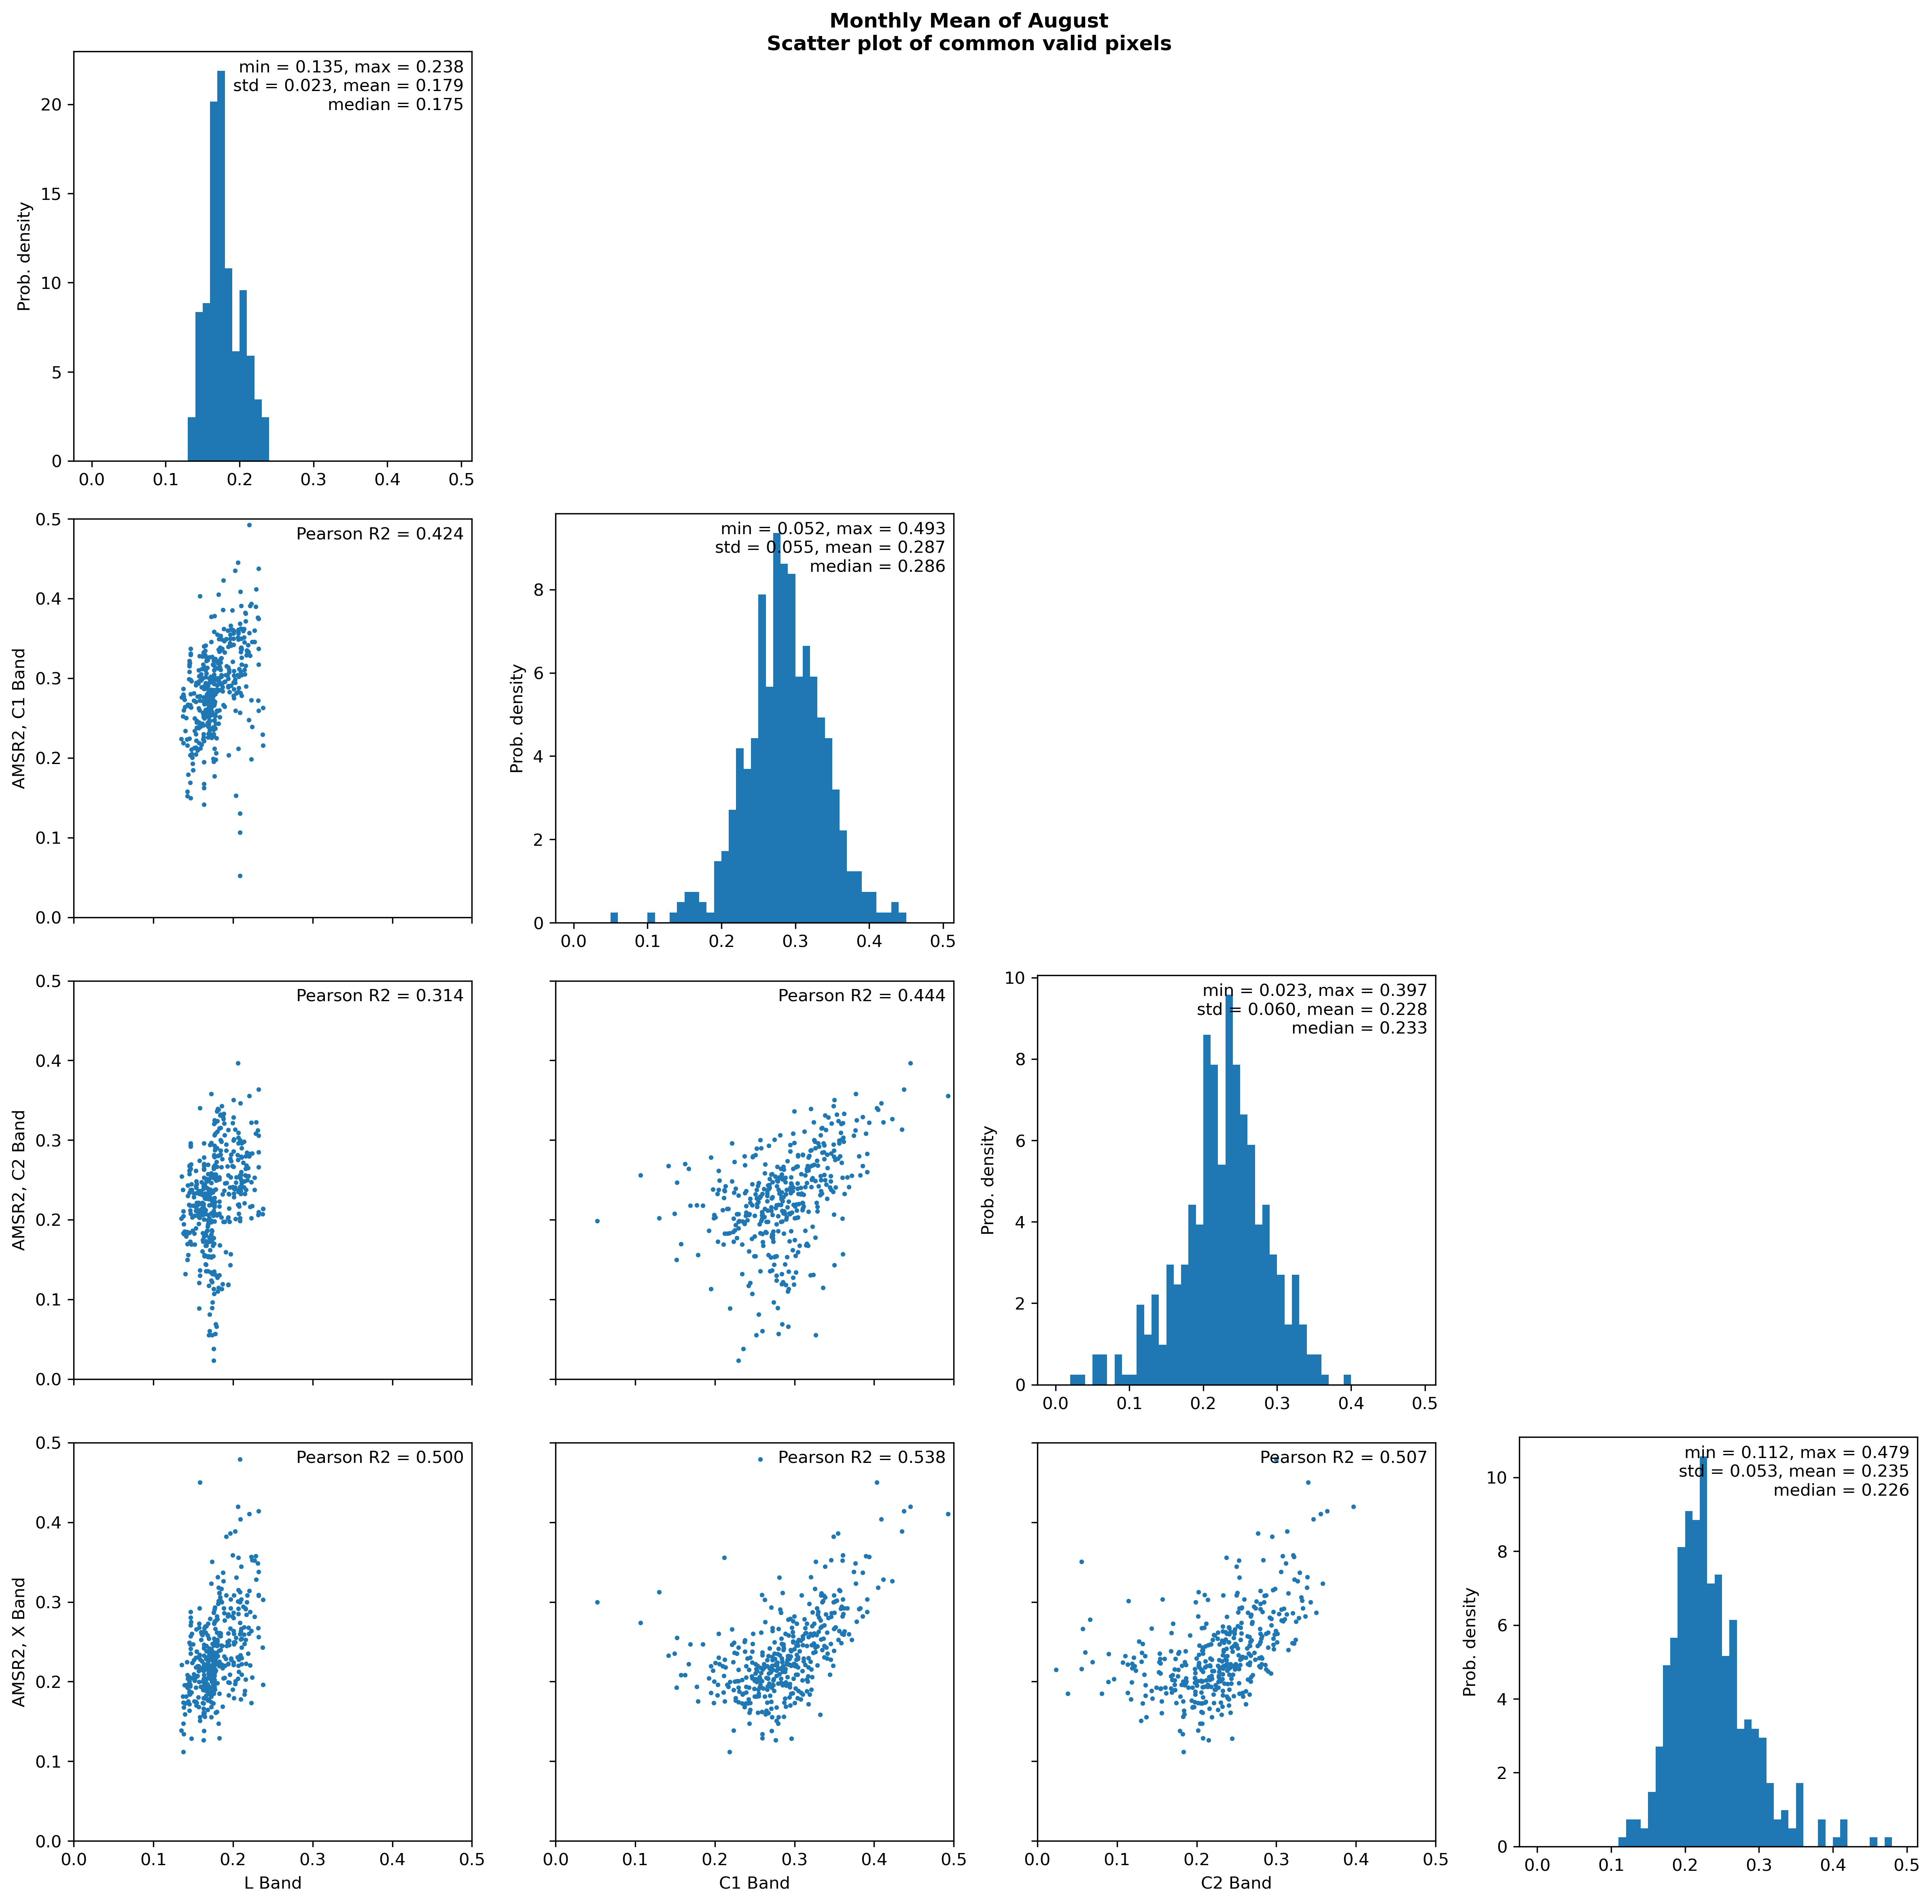

In [10]:
hist_bins = np.arange(0, 0.5, 0.01)
fig = plt.figure(figsize=(16, 16), dpi=dpi)
ax_arr = fig.subplots(len(roi_sflag_dict), len(roi_sflag_dict))
for i, k1 in enumerate(roi_sflag_dict.keys()):
    for j, k2 in enumerate(roi_sflag_dict.keys()):
        ax = ax_arr[i, j]
        if i < j:
            ax.set_visible(False)
            continue
            
        y = roi_temporal_mean_dict[k1][roi_sflag_all]        
        if i==j:
            ax.hist(y, bins=hist_bins, density=True)
            ax.set_ylabel('Prob. density')
#             ax.set_xlabel('{0:s}, {1:s} Band'.format(k1[0].upper(), k1[1]))
            textstr = ('min = {0:.3f}, max = {1:.3f}\n' 
                + 'std = {3:.3f}, mean = {2:.3f}\n' 
                + 'median = {4:.3f}\n')
            textstr = textstr.format(np.nanmin(y), 
                                     np.nanmax(y), 
                                     np.nanmean(y), 
                                     np.nanstd(y), 
                                     np.nanmedian(y))
            ax.text(0.98, 0.98, textstr, 
                    va='top', ha='right', transform=ax.transAxes)
            continue
            
        y_err = roi_temporal_std_dict[k1][roi_sflag_all]
        x = roi_temporal_mean_dict[k2][roi_sflag_all]
        x_err = roi_temporal_std_dict[k2][roi_sflag_all]
        
        ax.scatter(x, y, s=3)
        pearson_r2 = np.corrcoef(x, y)[0, 1]
        textstr = ('Pearson R2 = {0:.3f}')
        textstr = textstr.format(pearson_r2)
        ax.text(0.98, 0.98, textstr, 
                va='top', ha='right', transform=ax.transAxes)
        ax.set_xlim(0, 0.5)
        ax.set_ylim(0, 0.5)
        ax.set_aspect(1)
        if j==0:
            ax.set_ylabel('{0:s}, {1:s} Band'.format(k1[0].upper(), k1[1]))
        else:
            plt.setp(ax.yaxis.get_ticklabels(), visible=False)
        if i==len(roi_sflag_dict)-1:
            ax.set_xlabel('{1:s} Band'.format(k2[0].upper(), k2[1]))
        else:
            plt.setp(ax.xaxis.get_ticklabels(), visible=False)
            
fig.suptitle('Monthly Mean of August\nScatter plot of common valid pixels', fontweight='bold')
fig.tight_layout()

### Temporal comparison of spatial mean per day

**Notice** that, 

__1. SMAP has much fewer valid pixels than AMSR2 after QA filtering.__

__2. The temporal variation in the current graphs very likely also contains temporal variations in daily spatial coverages.__

In [11]:
scale_factor_dict = {'smap':1, 'amsr2':1e-2}
stats_list = [None]*len(raster_list_ss)

roi_sflag_all = None
for i, (k, raster_fname) in enumerate(raster_list_ss.iteritems()):
    raster_ds = rasterio.open(raster_fname)
    roi_img, roi_transform = rasterio.mask.mask(raster_ds, roi_shapes, 
                                                all_touched=True, crop=True, indexes=1)
    roi_img = roi_img.astype(np.float)
    roi_img[roi_img==raster_ds.nodatavals[0]] = np.nan
    roi_img = roi_img * scale_factor_dict[k[0]]
    raster_ds.close()
    stats_list[i] = pd.Series(roi_img.flatten()).describe(percentiles=[0.02, 0.25, 0.50, 0.75, 0.98])
    
    if roi_sflag_all is None:
        roi_sflag_all = np.logical_not(np.isnan(roi_img))
    else:
        roi_sflag_all = np.logical_and(roi_sflag_all, np.isnan(roi_img))
stats_df = pd.concat(stats_list, axis=1).T
stats_df.index = raster_list_ss.index

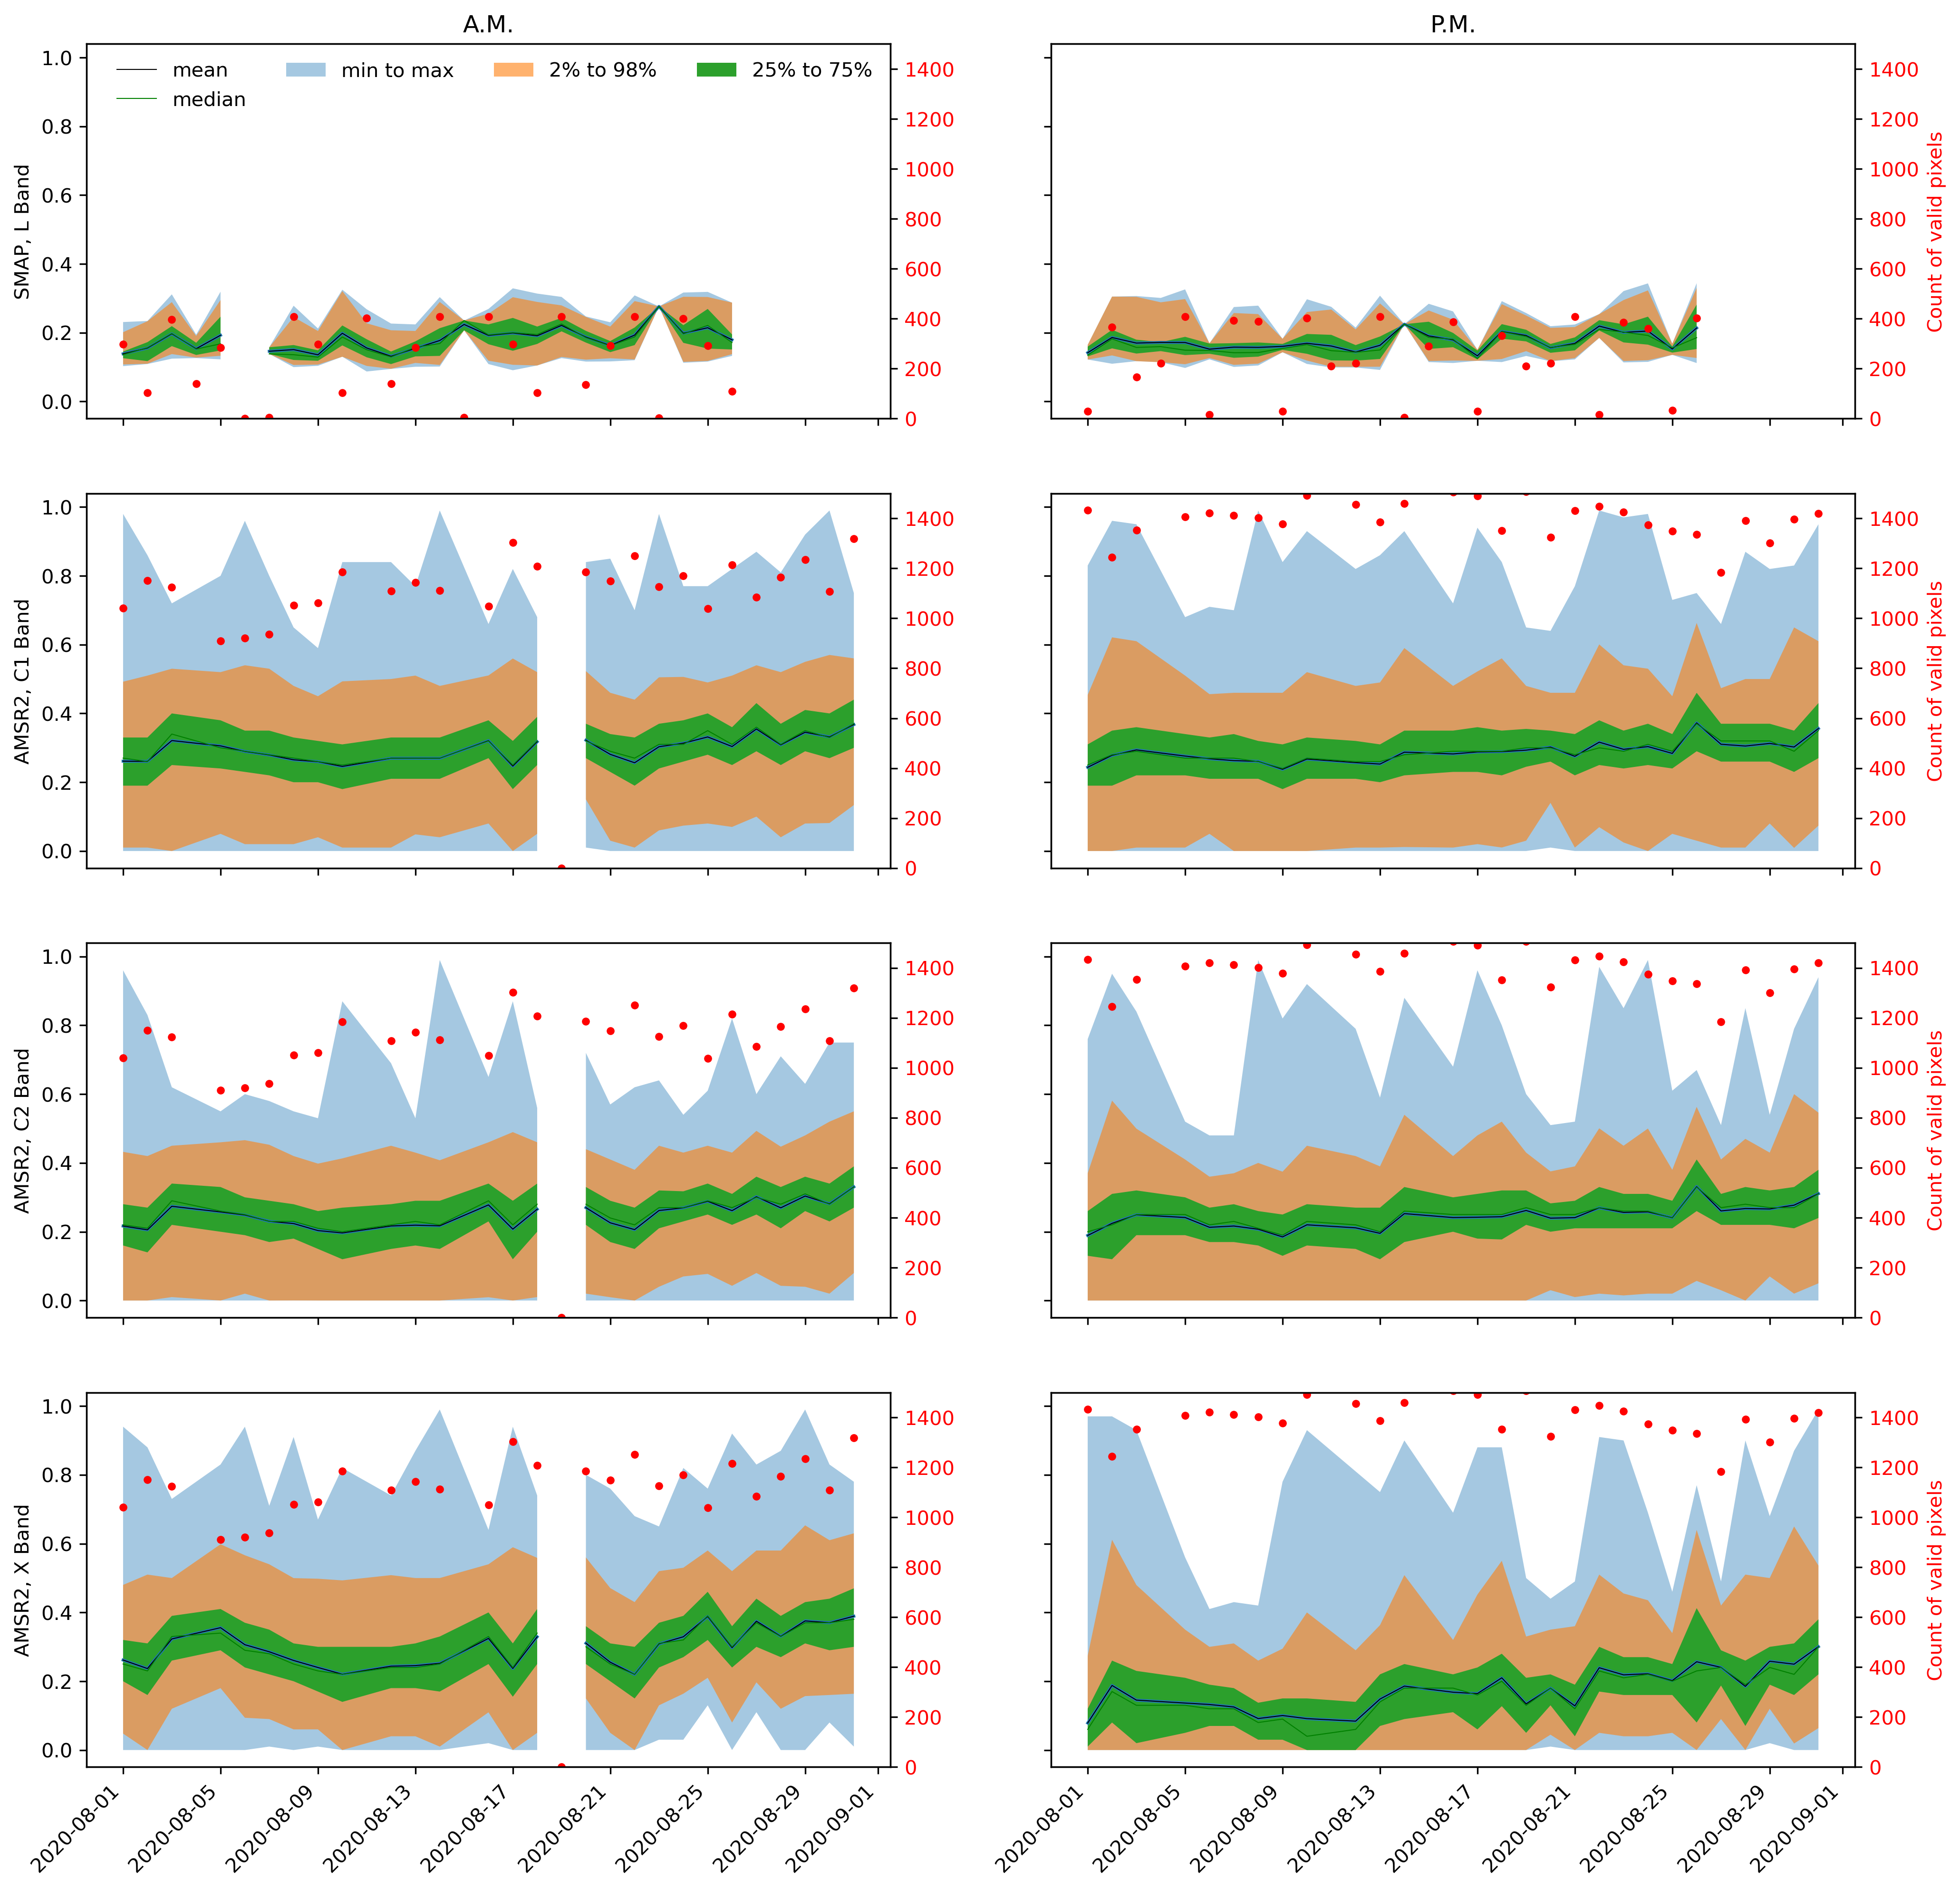

In [12]:
plot_row_labels = stats_df.index.droplevel(['asc/dsc', 'date']).unique().values
plot_col_labels = stats_df.index.get_level_values('asc/dsc').unique().values
fig = plt.figure(figsize=(16, 16), dpi=dpi)
ax_arr = fig.subplots(len(plot_row_labels), len(plot_col_labels), sharex=True, sharey=True)
for i, rowk in enumerate(plot_row_labels):
    for j, colk in enumerate(plot_col_labels):
        ax = ax_arr[i, j]
        cur_df = stats_df.loc[(*rowk, colk, slice(None)), :].droplevel(['sensor', 'band', 'asc/dsc'])
        ax.plot(cur_df.index, cur_df['mean'])
        
        ax.plot(cur_df.index, cur_df['mean'], 
                '-k', linewidth=0.5, label='mean')
        ax.plot(cur_df.index, cur_df['50%'], 
                '-g', linewidth=0.5, label='median')
        ax.fill_between(cur_df.index, 
                        cur_df['min'], 
                        cur_df['max'], 
                        alpha=0.4, 
                        label='min to max')
        ax.fill_between(cur_df.index, 
                        cur_df['2%'], 
                        cur_df['98%'], 
                        alpha=0.6, 
                        label='2% to 98%')
        ax.fill_between(cur_df.index, 
                        cur_df['25%'], 
                        cur_df['75%'], 
                        label='25% to 75%')
        if i==0 and j==0:
            ax.legend(ncol=4, frameon=False)
        if i==0:
            ax.set_title('A.M.' if colk=='dsc' else 'P.M.')
        if j==0:
            ax.set_ylabel('{0:s}, {1:s} Band'.format(rowk[0].upper(), rowk[1]))
        for val in ax.get_xticklabels():
            val.set_rotation(45)
            val.set_horizontalalignment('right')
            
        ax_r = ax.twinx()
        ax_r.plot(cur_df.index, cur_df['count'], '.r')
        if j==1:
            ax_r.set_ylabel('Count of valid pixels', color='r')
        plt.setp(ax_r.get_yticklabels(), color='r')
        ax_r.set_ylim(0, 1500)
